<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Analysis_of_EPI2ME_16S_CSV_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Analysis of EPI2ME 16S CSV Output</h1>

The EPI2ME 16S (and WIMP) analyses allow the download of a summary table of the results. However this table does not contain full lineage information and so it is not immediately useful to create the Sankey tree diagrams that EPI2ME displays in its web interface.

The following short code fragments, demonstrate how to decorate the EPI2ME data table and aggregate the read counts. 

An example 16S report can be found [here](https://epi2me.nanoporetech.com/workflow_instance/242318?token=6FF8C4B6-D055-11EA-A7B7-23477BC332F9).

Computational requirements for this tutorial:

* A computer running the **EPI2ME Labs** server
* 8Gb RAM

## Getting started

⚠️  ***Reminder:*** Connect to your locally running EPI2ME Labs Server before running any of the code below. See [Run a tutorial](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/epi2me-labs-server.ipynb#scrollTo=r--DdCunUR6Y) on the EPI2ME Labs Server help page for more information.

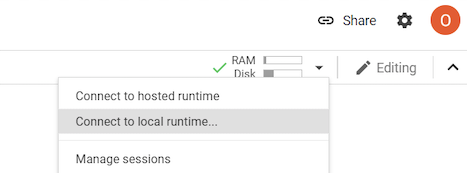

Having connected to the EPI2ME Labs Server, before anything else we will create and set a working directory:

In [1]:
from epi2melabs import ping
tutorial_name = "16s_lineage"
pinger = ping.Pingu()

# create a work directory and move into it
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/16s_lineage


### Install additional software

In order to decorate the EPI2ME results file with lineage information we will use the [taxonkit](https://bioinf.shenwei.me/taxonkit/) tool. The codebox below will download this tool and also `csvkit` which we will use to convert the EPI2ME file from a comma-separated file to a tab-seperated file (which taxonkit requires

*Please note that the software installed is not persistent and this step will need to be re-run if you stop and restart the EPI2ME Labs server.*

In [ ]:
!pip install csvkit
!wget https://github.com/shenwei356/taxonkit/releases/download/v0.6.0/taxonkit_linux_amd64.tar.gz
!tar -xzvf taxonkit_linux_amd64.tar.gz

Taxonkit requires the NCBI taxonomy database to function, let's download and decompress that:

In [ ]:
!mkdir -p "$working_dir"/taxdump
%cd "$working_dir/taxdump"
!wget http://ftp.ncbi.nih.gov/pub/taxonomy/taxdump.tar.gz
!tar -xzvf taxdump.tar.gz
%cd "$working_dir"

We now have all we need to get going:
- the EPI2ME results
- taxonkit
- The NCBI taxonomy

### Using your own data

For demonstration purposes this notebook can download and use a sample dataset.

If you have your own sequencing, you can edit the value of the input variables below in the **Data Entry** section. To find the correct full path of a file you can navigate to it in the **Files** browser to the left-hand side, right-click on the file and select **Copy path**:

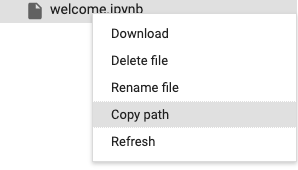

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.

### Data Entry

Please select to use the sample data, or enter your own.

In [7]:
import os
use_sample_data = True #@param {type:"boolean"}
epi2me_results_file = "" #@param {type:"string"}
#@markdown Output file for annotated table:
annotated_output = "/epi2melabs/16s_lineage/epi2me_results_with_lineage.csv" #@param {type:"string"}

if use_sample_data:
    print("Using sample data")
    bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
    domain = "s3-eu-west-1.amazonaws.com"
    site = "https://{}.{}".format(bucket, domain)
    
    fname = "242318_classification_16s_barcode-v1.csv"
    
    !echo "Downloading sample data"
    !wget -q $site/misc/$fname \
        && echo "Download complete" || echo "Download failed"
    !echo
    epi2me_results_file = os.path.abspath(fname)
else:
    print("Using user provided file: {}".format(epi2me_results_file))
if not os.path.isfile(epi2me_results_file):
    print("File does not exist")
print("\nFirst 10 lines of file:")
!head "$epi2me_results_file" || echo "File not readable"

pinger.send_notebook_ping('start', tutorial_name)

Using sample data
Download complete


First 10 lines of file:
readid,runid,barcode,exit_status,taxid,species_taxid,species,accuracy,genus_taxid,genus,lca
0003c930-069c-4c63-a8df-1a0ca50992c4,711db73c212e422fad11ca3c0ed596fc,NA,Classification successful,404937,404937,Anoxybacillus thermarum,93.88,150247,Anoxybacillus,0
000d4674-7d99-4fed-8ba6-ab5781ab95b7,711db73c212e422fad11ca3c0ed596fc,NA,Classification successful,43657,43657,Pseudoalteromonas luteoviolacea,93.37,53246,Pseudoalteromonas,0
00248183-faee-4f5b-a9fe-feb8e241db92,711db73c212e422fad11ca3c0ed596fc,NA,Classification successful,1855725,1855725,Mucilaginibacter antarcticus,95.5,423349,Mucilaginibacter,0
0029656e-5028-48e5-8822-0ba770d9ccf6,711db73c212e422fad11ca3c0ed596fc,NA,Classification successful,878213,878213,Actinomycetospora iriomotensis,92.25,402649,Actinomycetospora,0
002b9804-6cd0-42cd-b86e-6c71cf01bf4e,711db73c212e422fad11ca3c0ed596fc,NA,Classification successful,2027860,2027860,Mucilaginibacter rubeus,93.07,423349,M

201

After entering your inputs below, select `Runtime > Run all` from the
menu at the top of the page. If you need to analyse a second file just come back here, change `epi2me_results_file` to a new value and then select `Runtime > Run after`.

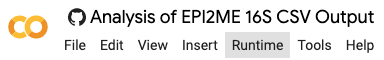

## Analysis

Let's first write a code function to read in and perform several conversions on the EPI2ME file. If you would like to use the methods of this notebook in your own code, this code cell is about all you will need:



In [8]:
#@markdown **Code for annotating an EPI2ME results file with lineage information**
import pandas as pd
import os
def parse_epi2me(fname):
    dirname = os.path.dirname(fname)
    tsvtmp = os.path.join(dirname, "epi2me2lineage.tsv")
    lintmp = os.path.join(dirname, "epi2me2lineage.lin.tmp")
    fmttmp = os.path.join(dirname, "epi2me2lineage.fmt.tmp")

    print("Converting to TSV")
    !csvformat -T "$fname" > "$tsvtmp"
    # need to know the position of the "taxid" column and the number of columns
    try:
        with open(tsvtmp, 'r') as fh:
            header = fh.readline().rstrip().split()
            taxid_col = 1 + header.index('taxid')
            lineage_col = 1 + len(header)  # this will be added in
    except:
        raise IndexError("Could not find 'taxid' column in input.")
    print("Running lineage")
    !"$working_dir/taxonkit" lineage --data-dir taxdump "$tsvtmp" -i "$taxid_col" 2>/dev/null > "$lintmp"
    print("Running reformat")
    !"$working_dir/taxonkit" reformat --data-dir taxdump -i "$lineage_col" "$lintmp" 2>/dev/null > "$fmttmp"
    print("Munging data")
    epi2me = pd.read_csv(fmttmp, sep='\t')
    # rename some columns so they don't clash with the lineage info
    epi2me.columns = epi2me.columns[0:len(epi2me.columns)-2].to_list() + ['_lineage', 'lineage']
    epi2me = epi2me.rename(columns={'species': 'species_name', 'genus':'genus_name'})
    # extract the lineage info into its on columns in the table
    lineage = epi2me['lineage'].str.split(";", expand=True)
    lineage.columns = ['kingdom', 'phylum', 'class', 'order', 'family','genus', 'species']
    epi2me = pd.concat((epi2me, lineage), axis=1)
    !rm -rf "$tsvtmp" "$lintmp" "$fmttmp"
    return epi2me

We can now read the input file, annotate it with the lineage information, and write out the annotated table.

In [9]:
epi2me = parse_epi2me(epi2me_results_file)
epi2me.to_csv(annotated_output)
pinger.send_notebook_ping('stop', tutorial_name)
print("Annotated data table written to: {}. Download from the filebrowser.".format(annotated_output))

Converting to TSV
Running lineage
Running reformat
Munging data
Annotated data table written to: /epi2melabs/16s_lineage/epi2me_results_with_lineage.csv. Download from the filebrowser.


The output table is the same as the input EPI2ME results file with additional columns indicating the taxonomic ranks to with each read has been assigned. For example, here is the start of the table:

In [43]:
epi2me = pd.read_csv(annotated_output)
display(epi2me.head())

,Unnamed: 0,readid,runid,barcode,exit_status,taxid,species_taxid,species_name,accuracy,genus_taxid,...,lca,_lineage,lineage,kingdom,phylum,class,order,family,genus,species
0,0,0003c930-069c-4c63-a8df-1a0ca50992c4,711db73c212e422fad11ca3c0ed596fc,NaN,Classification successful,404937.0,404937.0,Anoxybacillus thermarum,93.88,150247.0,...,0.0,cellular organisms;Bacteria;Terrabacteria grou...,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Anoxybacillus,Anoxybacillus thermarum
1,1,000d4674-7d99-4fed-8ba6-ab5781ab95b7,711db73c212e422fad11ca3c0ed596fc,NaN,Classification successful,43657.0,43657.0,Pseudoalteromonas luteoviolacea,93.37,53246.0,...,0.0,cellular organisms;Bacteria;Proteobacteria;Gam...,Bacteria;Proteobacteria;Gammaproteobacteria;Al...,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Pseudoalteromonadaceae,Pseudoalteromonas,Pseudoalteromonas luteoviolacea
2,2,00248183-faee-4f5b-a9fe-feb8e241db92,711db73c212e422fad11ca3c0ed596fc,NaN,Classification successful,1855725.0,1855725.0,Mucilaginibacter antarcticus,95.50,423349.0,...,0.0,cellular organisms;Bacteria;FCB group;Bacteroi...,Bacteria;Bacteroidetes;Sphingobacteriia;Sphing...,Bacteria,Bacteroidetes,Sphingobacteriia,Sphingobacteriales,Sphingobacteriaceae,Mucilaginibacter,Mucilaginibacter antarcticus
3,3,0029656e-5028-48e5-8822-0ba770d9ccf6,711db73c212e422fad11ca3c0ed596fc,NaN,Classification successful,878213.0,878213.0,Actinomycetospora iriomotensis,92.25,402649.0,...,0.0,cellular organisms;Bacteria;Terrabacteria grou...,Bacteria;Actinobacteria;Actinobacteria;Pseudon...,Bacteria,Actinobacteria,Actinobacteria,Pseudonocardiales,Pseudonocardiaceae,Actinomycetospora,Actinomycetospora iriomotensis
4,4,002b9804-6cd0-42cd-b86e-6c71cf01bf4e,711db73c212e422fad11ca3c0ed596fc,NaN,Classification successful,2027860.0,2027860.0,Mucilaginibacter rubeus,93.07,423349.0,...,0.0,cellular organisms;Bacteria;FCB group;Bacteroi...,Bacteria;Bacteroidetes;Sphingobacteriia;Sphing...,Bacteria,Bacteroidetes,Sphingobacteriia,Sphingobacteriales,Sphingobacteriaceae,Mucilaginibacter,Mucilaginibacter rubeus


With this data table we can now extract counts of reads at any of the taxonomic ranks, for example:

In [49]:
#@markdown **Aggregate counts by rank**

#@markdown Select a rank to aggregate read counts and then click the `Play` button
#@markdown to the left-hand side.
aggregation_rank = "family" #@param ['kingdom', 'phylum', 'class', 'order', 'family','genus', 'species']
split_by_barcode = False #@param {type:"boolean"}

def replace_empty(index):
    try:
        idx = index.index('')
    except ValueError:
        pass
    else:
        index[idx] = 'Unknown'
    return index

if not split_by_barcode:
    results = (
        epi2me[aggregation_rank]
        .value_counts()
        .reset_index()
        .rename(columns={'index':aggregation_rank, aggregation_rank:'count'}))
    results[aggregation_rank] = replace_empty(results[aggregation_rank].tolist())
    results.sort_values('count', ascending=False, inplace=True)
else:
    results = (
        epi2me[[aggregation_rank, 'barcode']]
        .groupby([aggregation_rank, 'barcode'])
        .size().unstack(fill_value=0))
    results['total'] = results.sum(axis=1)
    results.sort_values('total', ascending=False, inplace=True)
    results.index = replace_empty(results.index.tolist())
print("Top 10 groups.")
display(results.head(10))
output = 'aggregated_counts_by_{}.csv'.format(aggregation_rank)
results.to_csv(output)
print("Results written to {}, download from the filebrowser.".format(output))


Top 10 groups.


,family,count
0,Streptomycetaceae,34593
1,Flavobacteriaceae,21471
2,Bacillaceae,17835
3,Rhodobacteraceae,15091
4,Paenibacillaceae,9618
5,Pseudonocardiaceae,9213
6,Sphingomonadaceae,8992
7,Microbacteriaceae,8443
8,Nocardiaceae,7945
9,Micromonosporaceae,7580


Results written to aggregated_counts_by_family.csv, download from the filebrowser.


### Some notes

The EPI2ME table provides a `taxid`, `species_taxid` and a `genus_taxid`. EPI2ME provides some sanity checking on its classification. If the top hits of a read are from different genera the `taxid` will be empty, that is to say the read is "Unclassified". The code above is using the value of the `taxid` field to derive the lineage information.